# Live session

## Wednesday 23rd March 2022

In [ ]:
import tensorflow as tf

### Question 1 (Total 30 marks)

This question uses the [CIFAR-10](https://keras.io/api/datasets/cifar10/) dataset, which you should load as follows:

In [ ]:
from tensorflow.keras.datasets import cifar10
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()

a) Randomly select 20 examples from the CIFAR-10 training dataset and display the images along with their (integer) labels. **(5 marks)**

In [ ]:
n_samples = cifar10_x_train.shape[0]

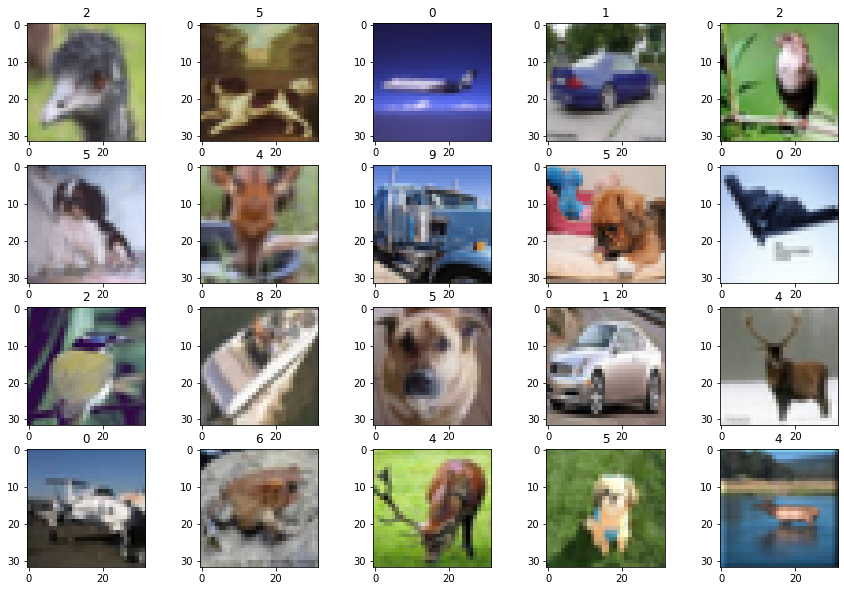

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sampled_inx = np.random.choice(n_samples, 20, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 10))

n = 0
for row in range(4):
    for col in range(5):
        axes[row, col].imshow(cifar10_x_train[sampled_inx[n]])
        axes[row, col].set_title(cifar10_y_train[sampled_inx[n]][0])
        n += 1

b) Use the Sequential API to implement an MLP classifier model for the CIFAR-10 dataset (as loaded above) with the following spec:

* The model first flattens the input image into a 1-D Tensor.
* The model then passes the image through 3 Dense layers of width 64, 32 and 16 respectively, using a sigmoid activation function.
* The final Dense layer has width 10, and no activation function.

Print the model summary, and compile it with a suitable optimizer and loss function, and an accuracy metric. **(10 marks)**

In [ ]:
cifar10_y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

mlp = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(64, activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(10)
])

In [ ]:
mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                196672    
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 10)                170       
                                                                 
Total params: 199,450
Trainable params: 199,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

mlp.compile(optimizer='rmsprop',
           loss=loss,
           metrics=['accuracy'])

c) Create a custom layer called `GlobalMaxAveragePooling2D`, that performs a global pooling operation over the spatial dimensions (height and width). 

* The layer initialiser should take one required argument `data_format`, which can take the values `'channels_first'` or `'channels_last'`, corresponding to the ordering of dimensions in the inputs.   
  * `'channels_first'` assumes that the input is of the form `(batch_size, channels, height, width)`
  * `'channels_last'` assumes that the input is of the form `(batch_size, height, width, channels)`
* The layer should compute the global **mean** pixel value per channel, as well as the global **max** pixel value per channel, i.e. it should reduce out the height and width dimensions
* The layer should then concatenate the result of the two global pooling operations, to return a Tensor of shape `(batch_size, 2*channels)`
* Your layer implementation should not make use of any other Keras layers or TensorFlow pooling functions. 
* Test your layer by instantiating it (create a `GlobalMaxAveragePooling2D` object) and calling it on a Tensor of shape `(2, 8, 6, 3)` filled with randomly sampled values. **(10 marks)**

_Hint: the `tf.reduce_max`, `tf.reduce_mean` and `tf.concat` functions will be useful in defining the custom layer._

In [ ]:
from tensorflow.keras.layers import Layer

class GlobalMaxAveragePooling2D(Layer):
    
    def __init__(self, data_format, name='global_max_average_pooling2d'):
        super().__init__(name=name)
        assert data_format in ['channels_first', 'channels_last']
        self.data_format = data_format
        if self.data_format == 'channels_first':
            self.reduce_axes = [-1, -2]  # [2, 3]
        else:
            self.reduce_axes = [-2, -3]  # [1, 2]
            
    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs,
                                 axis=self.reduce_axes)
        max_pool = tf.reduce_max(inputs,
                                axis=self.reduce_axes)
        return tf.concat([avg_pool, max_pool], axis=-1)  # axis=1

In [ ]:
globalmaxaveragepool = GlobalMaxAveragePooling2D('channels_last')

dummy_input = tf.random.normal((2, 8, 6, 3))
globalmaxaveragepool(dummy_input)

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[ 0.17831041,  0.00961297, -0.07586168,  1.7538905 ,  2.512964  ,
         2.0112693 ],
       [-0.12225037, -0.26700678, -0.22836785,  2.398349  ,  1.798874  ,
         2.4976742 ]], dtype=float32)>

d) Use the Sequential API to implement a CNN classifier model for the CIFAR-10 dataset (as loaded above), using any number of `Conv2D` layers, one `GlobalMaxAveragePooling2D` layer and one `Dense` layer. Your `Conv2D` layers can use any hyperparameter settings. 

Your CNN model should have roughly the same number of trainable parameters as the MLP model above (within $\pm 10\%$). Print the model summary. **(5 marks)**

In [ ]:
199450 * 1.1, 199450 * 0.9

(219395.00000000003, 179505.0)

In [ ]:
from tensorflow.keras.layers import Conv2D

cnn = Sequential([
    Conv2D(128, 5, activation='relu', input_shape=(32, 32, 3)),
    Conv2D(64, 5, activation='relu'),
    Conv2D(8, 3, activation='relu'),
    GlobalMaxAveragePooling2D('channels_last'),
    Dense(10, activation='softmax')
])

In [ ]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       9728      
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        204864    
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 8)         4616      
                                                                 
 global_max_average_pooling2  (None, 16)               0         
 d (GlobalMaxAveragePooling2                                     
 D)                                                              
                                                                 
 dense_9 (Dense)             (None, 10)                170       
                                                                 
Total params: 219,378
Trainable params: 219,378
Non-tr

### Question 2 (Total 30 marks)

This question uses the [CIFAR-10](https://keras.io/api/datasets/cifar10/) dataset, which you should load as follows:

In [ ]:
from tensorflow.keras.datasets import cifar10
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()

a) Create train and test `tf.data.Dataset` objects for the CIFAR-10 dataset, that return a tuple of input images and integer labels. 

You should then write the following functions to process the input images:

* Write a function `rescale` that converts the images to type `tf.float32` and rescales the pixel values to lie in the range $[-1, 1]$
* Write a function `grayscale` that converts the input images to grayscale by averaging the pixel values of the colour channels. The image Tensors should retain the channel axis, with length 1.
* Write a function `random_flip` that randomly flips the input image horizontally, with probability $0.5$

Apply each of the functions above in sequence to the train and test `tf.data.Dataset` objects using the `map` method and print out the `element_spec`. Do not batch or shuffle your Datasets. **(17 marks)** 

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((cifar10_x_train, cifar10_y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((cifar10_x_test, cifar10_y_test))

train_dataset.element_spec

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(1,), dtype=tf.uint8, name=None))

In [ ]:
def rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = (image * (2./255.)) - 1.
    return image, label

def grayscale(image, label):
    image = tf.reduce_mean(image, axis=-1, keepdims=True)
    return image, label

def random_flip(image, label):
#     return tf.image.random_flip_left_right(image), label
    sample = tf.random.uniform((), 
                              minval=0., maxval=1.)

#     sample = np.random.uniform(low=0, high=1, size=1)
    
#     if sample < 0.5:
#         return image[:, ::-1, :], label
#     else:
#         return image, label

    image = tf.cond(sample < 0.5,
                   lambda : tf.reverse(image, axis=[-2]),
                   lambda : image)
    return image, label

In [ ]:
train_dataset = train_dataset.map(rescale)
train_dataset = train_dataset.map(grayscale)
train_dataset = train_dataset.map(random_flip)

test_dataset = test_dataset.map(rescale)
test_dataset = test_dataset.map(grayscale)
test_dataset = test_dataset.map(random_flip)

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(1,), dtype=tf.uint8, name=None))

b) Write a function `filter_classes` that you will use with the Datasets' `filter` method, to filter out examples with any of the class labels $[0, 1, 8, 9]$.

Apply your function to the train and test Datasets with the `filter` method, and verify your function works correctly by iterating through the Datasets and confirming that the examples returned by the Datasets only contain the integer labels $[3, 4, 5, 6, 7]$. **(8 marks)**

In [ ]:
def filter_classes(image, label):
    not_allowed = tf.constant([0, 1, 8, 9])
    label = tf.cast(label, tf.int32)
    return tf.math.logical_not(tf.reduce_any(tf.math.equal(label, not_allowed)))

In [ ]:
train_dataset = train_dataset.filter(filter_classes)
test_dataset = test_dataset.filter(filter_classes)

In [ ]:
labels = set()

for _, l in train_dataset:
    l = int(l[0].numpy())
    labels.add(l)
    
for _, l in test_dataset:
    l = int(l[0].numpy())
    labels.add(l)
    
print("Found labels:", labels)

Found labels: {2, 3, 4, 5, 6, 7}


c) Batch your Dataset objects with a batch size of 20 (but do not shuffle them). 

Draw one batch of examples from your training Dataset and display them along with their string label names. The label names are provided below. **(5 marks)**

In [ ]:
# These label names correspond with the integer labels loaded above

class_names = [
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]

In [ ]:
train_dataset = train_dataset.batch(20)
test_dataset = test_dataset.batch(20)

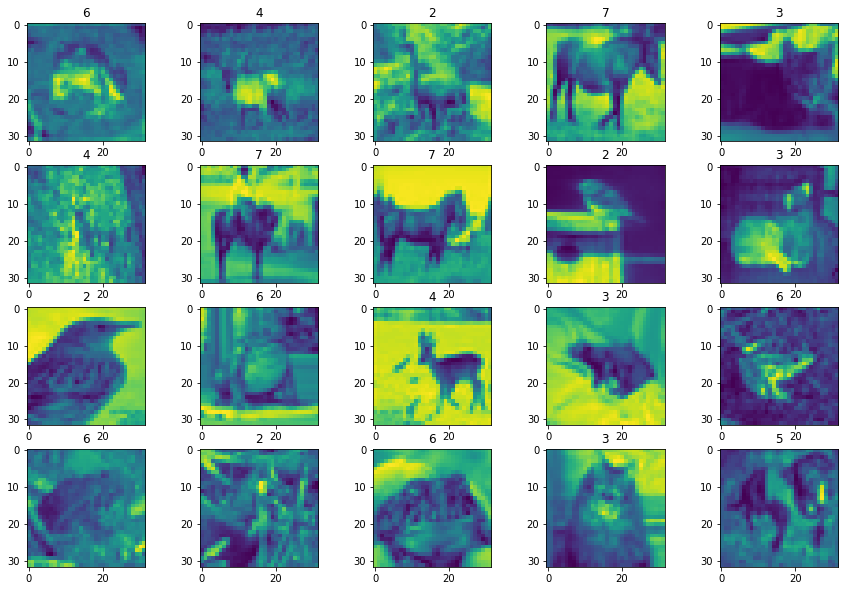

In [ ]:
for images, labels in train_dataset.take(1):
    images, labels = images.numpy(), labels.numpy()

fig, axes = plt.subplots(4, 5, figsize=(15, 10))

n = 0
for row in range(4):
    for col in range(5):
        axes[row, col].imshow(images[n])
        axes[row, col].set_title(labels[n][0])
        n += 1

### Question 3 (Total 40 marks)

This question uses the [MNIST](https://keras.io/api/datasets/mnist/) dataset, which you should load as follows (this question only uses the train split):

In [ ]:
from tensorflow.keras.datasets import mnist
(mnist_x_train, mnist_y_train), _ = mnist.load_data()

a) Create a `tf.data.Dataset` object from the train split arrays loaded above, that returns a tuple of input images and integer labels.

* Process the input images by rescaling the pixel values to the range $[0, 1]$
* Shuffle the Dataset with buffer size 1000
* Batch the Dataset with batch size 64

**(5 marks)**

In [ ]:
mnist_train_ds = tf.data.Dataset.from_tensor_slices((mnist_x_train, mnist_y_train))

In [ ]:
def rescale_mnist(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    return image, label

mnist_train_ds = mnist_train_ds.map(rescale_mnist)

In [ ]:
mnist_train_ds = mnist_train_ds.shuffle(1000).batch(64)

In [ ]:
mnist_train_ds.element_spec

(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

b) Use the functional API to implement an MLP classification model for the MNIST dataset.

Your model should first flatten the input image into a 1-D Tensor, and should have a single hidden layer with 100 neurons and a ReLU activation. The output layer is a softmax layer with 10 classes. Compile your model with a suitable loss function and the SGD optimizer. Print the model summary. **(7 marks)**

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Flatten, Dense

inputs = Input(shape=(28, 28))
h = Flatten()(inputs)
h = Dense(100, activation='relu')(h)
outputs = Dense(10, activation='softmax')(h)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


c) A common method for finding a suitable learning rate for a given model and optimizer is to perform a dummy training run as a learning rate probe as follows:

* Set the initial learning rate to a small value
* Fix a number of iterations to train the model, `num_iterations` 
* After each iteration/batch, slightly increase the learning rate by multiplying by a fixed factor $q>1$
* Repeat until the learning rate reaches a high value, recording the loss at each training iteration

The aim is to obtain a plot that looks something like this:
<img src="figures/example_loss_lr_curve.png" alt="Life expectancy" style="width: 350px;"/>
The loss decreases in the beginning, but eventually starts rising when it is too large. A good choice of learning rate is one slightly to the left of the minimum.

Write a custom callback `LearningRateProbe` to implement the above scheme. 

* The initializer should take the arguments `num_iterations`, `initial_learning_rate` and `final_learning_rate`
* The callback should set the optimizer learning rate to `initial_learning_rate` at the start of training, and then increase it by a factor of $q$ after each training iteration
  * The factor $q$ should be calculated to satisfy:
  
  `initial_learning_rate * q**(num_iterations - 1) = final_learning_rate`
  
* After each training iteration, the callback should store the learning rate values and the loss values
  
_Hint: the optimizer learning rate is a non-trainable TensorFlow Variable stored at `model.optimizer.lr`, for a compiled model. This Variable should be updated after each training iteration as above._ **(18 marks)**

In [ ]:
from tensorflow.keras.callbacks import Callback

class LearningRateProbe(Callback):
    
    def __init__(self, num_iterations, initial_learning_rate, final_learning_rate,
                 max_epochs=None):
        super().__init__()
        self.num_iterations = num_iterations
        self.initial_learning_rate = initial_learning_rate
        self.final_learning_rate = final_learning_rate
        self.q = (final_learning_rate / initial_learning_rate) ** (
            1 / (num_iterations-1))
        self.loss_values = []
        self.lr_values = []
        self.max_epochs = max_epochs
        
    def on_epoch_begin(self, epoch, logs=None):
        if (self.max_epochs is not None) and (epoch >= self.max_epochs):
            self.model.stop_training = True
        
    def on_train_begin(self, logs=None):
        self.lr = self.initial_learning_rate
        self.model.optimizer.lr.assign(self.lr)
        
    def on_train_batch_end(self, batch, logs=None):
        loss = logs['loss']
        self.loss_values.append(loss)
        self.lr_values.append(self.lr)
        
        self.lr *= self.q
        self.model.optimizer.lr.assign(self.lr)

d) Use your `LearningRateProbe` callback to collect the loss values from training your (freshly initialized) model from part a) for a single epoch on the MNIST training data, with the batch size of 64.

* Set `num_iterations` to 938 (number of batches of size 64 in a single epoch through a training set of 60,000 examples)
* Set `initial_learning_rate` to $1e-8$
* Set `final_learning_rate` to $10$
* Train your model for 1 epoch, passing in your `LearningRateProbe` custom callback object
* Plot the loss values against the learning rate, using a log scale for the x-axis
* Calculate the learning rate that minimizes the loss curve, and suggest a good learning rate for this model, dataset and optimizer

**(10 marks)**

In [ ]:
lr_probe = LearningRateProbe(num_iterations=938,
                            initial_learning_rate=1e-8,
                            final_learning_rate=10)

In [ ]:
history = model.fit(mnist_train_ds, epochs=1, callbacks=[lr_probe])

938/938 [==============================] - 4s 4ms/step - loss: 2.4352


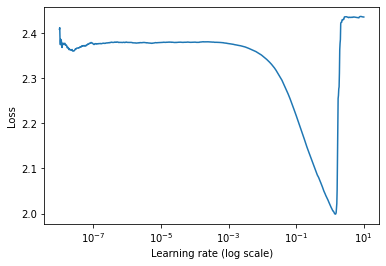

In [ ]:
plt.semilogx(lr_probe.lr_values, lr_probe.loss_values)
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Loss")
plt.show()

In [ ]:
inx = np.argmin(lr_probe.loss_values)
print("Suggested LR",lr_probe.lr_values[inx] / 10.)

Suggested LR 0.14600049301200085
